In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns
import time

import astropy
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.table import Table, join

from dustmaps.sfd import SFDQuery

import healpy as hp
import pandas as pd
from sklearn.neighbors import KDTree

In [2]:
# -------------------------------------------------------------------------------
# plotting settings
# -------------------------------------------------------------------------------

colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple", "pale red"]
colors = sns.xkcd_palette(colors)
#colors = sns.color_palette("Blues")

matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)
fsize = 18

colors_cont = ["black", "grey", "light grey"] 
colors_cont = sns.xkcd_palette(colors_cont)

np.random.seed(40)

## Read in data

In [3]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_gaia_all = Table.read('../data/gaia_slim.fits', format='fits')
print('Total number of Gaia quasars:', len(tab_gaia_all))

Total number of Gaia quasars: 6649162


In [4]:
tab_gaia_all.keys()

['ra',
 'dec',
 'redshift_qsoc',
 'l',
 'b',
 'source_id',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'phot_g_mean_mag',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'redshift_qsoc_lower',
 'redshift_qsoc_upper',
 'zscore_qsoc',
 'flags_qsoc',
 'allwise_oid',
 'w1mpro',
 'w2mpro',
 'g_rp',
 'bp_g',
 'bp_rp',
 'g_w1',
 'w1_w2',
 'ebv',
 'A_v',
 'pm']

In [5]:
np.sum(tab_gaia_all['phot_g_mean_mag'] < 20.4)

3557119

In [6]:
G_max_spz = 20.5
fn_spz = f'../data/redshifts_spz_kNN_G{G_max_spz}_noself.fits'
tab_spz = Table.read(fn_spz, format='fits')
len(tab_spz)

6649162

In [7]:
tab_gaia = astropy.table.join(tab_gaia_all, tab_spz, keys='source_id', join_type='left')
len(tab_gaia)

6649162

In [8]:
idx_withspz = np.isfinite(tab_gaia['redshift_spz'])
np.sum(idx_withspz)

1104830

In [9]:
idx_withsdss = np.isfinite(tab_gaia['redshift_sdss'])
np.sum(idx_withsdss)

260114

In [10]:
fn_sdss = '../data/sdss_slim.fits'
tab_sdss = Table.read(fn_sdss, format='fits')

In [11]:
fn_sdss_full = '../data/SDSS_DR16Q_v4.fits'
tab_sdss_full = Table.read(fn_sdss_full, format='fits')

In [12]:
tab_sdss_full.keys()

['SDSS_NAME',
 'RA',
 'DEC',
 'PLATE',
 'MJD',
 'FIBERID',
 'AUTOCLASS_PQN',
 'AUTOCLASS_DR14Q',
 'IS_QSO_QN',
 'Z_QN',
 'RANDOM_SELECT',
 'Z_10K',
 'Z_CONF_10K',
 'PIPE_CORR_10K',
 'IS_QSO_10K',
 'THING_ID',
 'Z_VI',
 'Z_CONF',
 'CLASS_PERSON',
 'Z_DR12Q',
 'IS_QSO_DR12Q',
 'Z_DR7Q_SCH',
 'IS_QSO_DR7Q',
 'Z_DR6Q_HW',
 'Z_DR7Q_HW',
 'IS_QSO_FINAL',
 'Z',
 'SOURCE_Z',
 'Z_PIPE',
 'ZWARNING',
 'OBJID',
 'Z_PCA',
 'ZWARN_PCA',
 'DELTACHI2_PCA',
 'Z_HALPHA',
 'ZWARN_HALPHA',
 'DELTACHI2_HALPHA',
 'Z_HBETA',
 'ZWARN_HBETA',
 'DELTACHI2_HBETA',
 'Z_MGII',
 'ZWARN_MGII',
 'DELTACHI2_MGII',
 'Z_CIII',
 'ZWARN_CIII',
 'DELTACHI2_CIII',
 'Z_CIV',
 'ZWARN_CIV',
 'DELTACHI2_CIV',
 'Z_LYA',
 'ZWARN_LYA',
 'DELTACHI2_LYA',
 'Z_LYAWG',
 'Z_DLA',
 'NHI_DLA',
 'CONF_DLA',
 'BAL_PROB',
 'BI_CIV',
 'ERR_BI_CIV',
 'AI_CIV',
 'ERR_AI_CIV',
 'BI_SIIV',
 'ERR_BI_SIIV',
 'AI_SIIV',
 'ERR_AI_SIIV',
 'BOSS_TARGET1',
 'EBOSS_TARGET0',
 'EBOSS_TARGET1',
 'EBOSS_TARGET2',
 'ANCILLARY_TARGET1',
 'ANCILLARY_TARGET2'

# G20.4

In [13]:
#tab_gaia = Table.read('../data/gaia_wise_panstarrs_tmass.fits.gz', format='fits')
tab_g = Table.read('../data/gaia_G20.4.fits', format='fits')
print('Gaia quasars with G<20.4 that make our color cuts:', len(tab_g))

Gaia quasars with G<20.4 that make our color cuts: 1001557


In [14]:
tab_g['redshift_sdss'][5]

masked

In [15]:
idx_gNOTsdss = tab_g['redshift_sdss'].mask # these are masked for some reason - but this works
print(np.sum(idx_gNOTsdss))

761659


23994


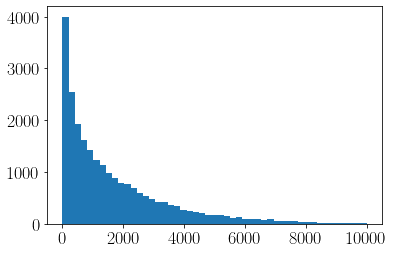

In [17]:
param_name = 'BI_CIV'
#bins = np.linspace(0, np.max(, 50)
vals = tab_sdss_full[param_name]
idx_hasbi = (vals!=0) & (vals!=-1)
bins = np.linspace(0, 10000, 50)
print(np.sum(idx_hasbi))
_ = plt.hist(vals[idx_hasbi], bins=bins)

107045


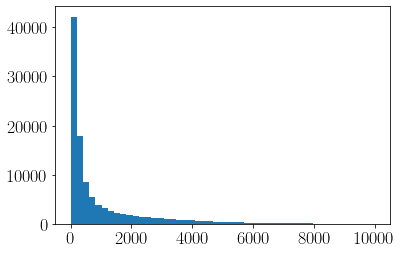

In [18]:
param_name = 'AI_CIV'
vals = tab_sdss_full[param_name]
idx_hasbi = (vals!=0) & (vals!=-1)
bins = np.linspace(0, 10000, 50)
print(np.sum(idx_hasbi))
_ = plt.hist(vals[idx_hasbi], bins=bins)

5970


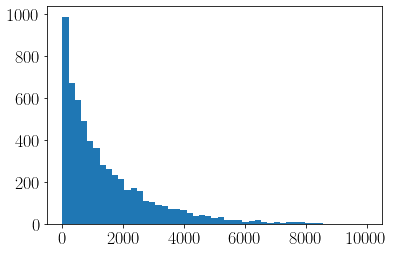

In [19]:
param_name = 'BI_SIIV'
vals = tab_sdss_full[param_name]
idx_hasbi = (vals!=0) & (vals!=-1)
bins = np.linspace(0, 10000, 50)
print(np.sum(idx_hasbi))
_ = plt.hist(vals[idx_hasbi], bins=bins)

# Investigate objects in Gaia but not SDSS

In [24]:
len(idx_gNOTsdss), len(idx_withsdss)

(1001557, 6649162)

In [48]:
i_G205 = tab_gaia_all['phot_g_mean_mag'] < 20.5

In [47]:
np.max(tab_gaia['phot_g_mean_mag'])
np.max(tab_gaia['phot_g_mean_mag'][idx_withsdss])

20.499992

IndexError: boolean index did not match indexed array along dimension 0; dimension is 6649162 but corresponding boolean dimension is 1001557

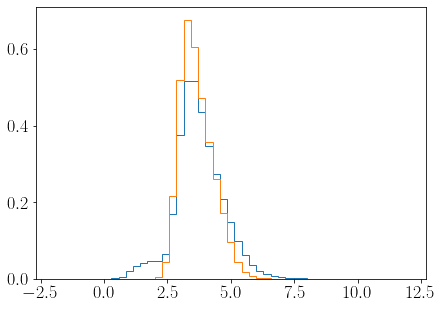

In [57]:
bins = np.linspace(-2, 12, 50)
density = True

plt.figure(figsize=(7,5))
plt.hist(tab_gaia_all['g_w1'][i_G205], histtype='step', bins=bins, label=r'Gaia $G<20.5$', density=density)
plt.hist(tab_gaia['g_w1'][idx_withsdss], histtype='step', bins=bins, label='+ Has SDSS match', density=density)
plt.hist(tab_gaia['g_w1'][idx_gNOTsdss], histtype='step', bins=bins, label='+ No SDSS match', density=density)

plt.xlabel(r'$G-W1$')
plt.ylabel("normalized number counts")
plt.legend()

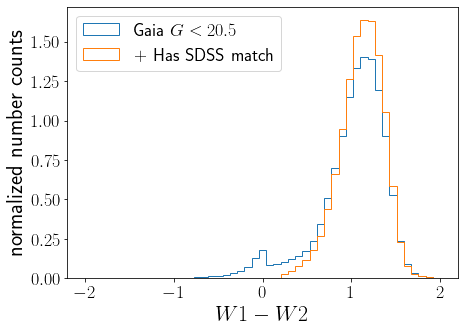

In [56]:
bins = np.linspace(-2, 2, 50)
density = True

plt.figure(figsize=(7,5))
plt.hist(tab_gaia_all['w1_w2'][i_G205], histtype='step', bins=bins, label=r'Gaia $G<20.5$', density=density)
plt.hist(tab_gaia['w1_w2'][idx_withsdss], histtype='step', bins=bins, label='+ Has SDSS match', density=density)

plt.xlabel(r'$W1-W2$')
plt.ylabel("normalized number counts")
plt.legend(loc='upper left')

# Look at proper motions

In [27]:
np.min(tab_gaia_all['pm']), np.max(tab_gaia_all['pm'])

(0.0005421096935336298, 1962.558190900727)

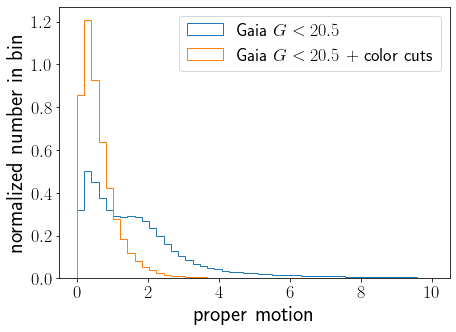

In [36]:
bins = np.linspace(0,10,50)
density=True

plt.figure(figsize=(7,5))
plt.hist(tab_gaia_all['pm'][i_G205], histtype='step', bins=bins, density=density, label=r'Gaia $G<20.5$')
plt.hist(tab_gaia['pm'][idx_withspz], histtype='step', bins=bins, density=density, label=r'Gaia $G<20.5$ + color cuts')
plt.xlabel("proper motion")
plt.ylabel("normalized number in bin")
plt.legend()